# Solution to Question # 3.

<strong>Objective:</strong>
Our goal is to construct a model which can predict fraudulent transactions automatically.

<strong>Tools Used:</strong> Pandas, Numpy, Matplotlib, Tensorflow, Keras, Scikit-learn

# 1 - Loading important libraries

In [89]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import tensorflow as tf
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


RANDOM_SEED = 42

In [90]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
%matplotlib inline

### Reading Data, Data Analysis and Exploration

In [50]:
data = pd.read_csv('Resources/fraud_one.csv')

In [51]:
data.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,64,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,...,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
1,1,64,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
2,2,124,1.105253,0.541842,0.839421,2.570933,-0.279517,-0.423062,0.088019,0.011622,...,-0.137434,-0.460991,0.189397,0.556329,0.185786,-0.189030,0.000208,0.026167,6.24,0
3,3,128,1.239495,-0.182609,0.155058,-0.928892,-0.746227,-1.235608,-0.061695,-0.125223,...,0.146077,0.481119,-0.140019,0.538261,0.710720,-0.621382,0.036867,0.010963,8.80,0
4,4,132,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,...,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,10.00,0


We can see that we have been provided with an annoymous dataset which is in numerical form in order to protect the privacy of the customer. We are not allowed to have real credit card information, expiry date, ip address or any other related information. The 'Class' column of the fraudData set indicates two values, 0 and 1. 0 represents transactions is fine and 1 represents if transaction may be fraudulent.

In [52]:
data.isnull().values.any()

False

In [53]:
data['Class'].value_counts()

0    7983
1      17
Name: Class, dtype: int64

In [54]:
data[["Time","Amount","Class"]].describe()

,Time,Amount,Class
count,8000.000000,8000.000000,8000.000000
mean,95357.290375,89.669246,0.002125
std,46956.240862,260.188804,0.046052
min,64.000000,0.000000,0.000000
25%,55189.750000,5.990000,0.000000
50%,85758.000000,22.855000,0.000000
75%,139042.750000,78.432500,0.000000
max,172766.000000,10199.440000,1.000000


In [55]:
print('No Frauds are ', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds are ', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds are  99.79 % of the dataset
Frauds are  0.21 % of the dataset


Our data is very much imbalanced (which is understandable since most of the transactions are in no frauds category). If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

''

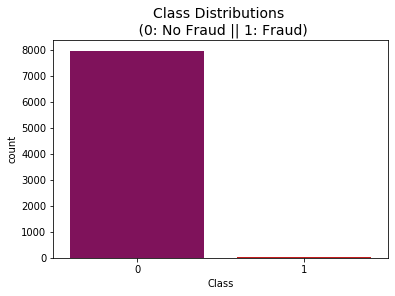

In [56]:
colors = ["#910061", "#DF0101"]

sns.countplot('Class', data=data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
;

### Distribution of Transaction Amount and Distribution of Transaction Time

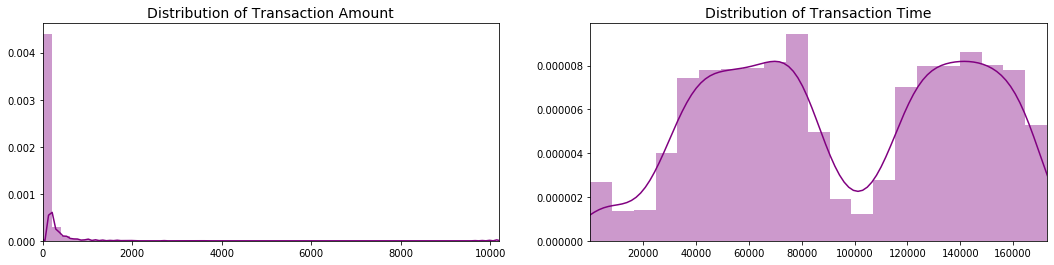

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='purple')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='purple')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [58]:
# time features -- converting time into minutes and hours

timedelta = pd.to_timedelta(data['Time'], unit='s')
data['Time_min'] = (timedelta.dt.components.minutes).astype(int)
data['Time_hour'] = (timedelta.dt.components.hours).astype(int)

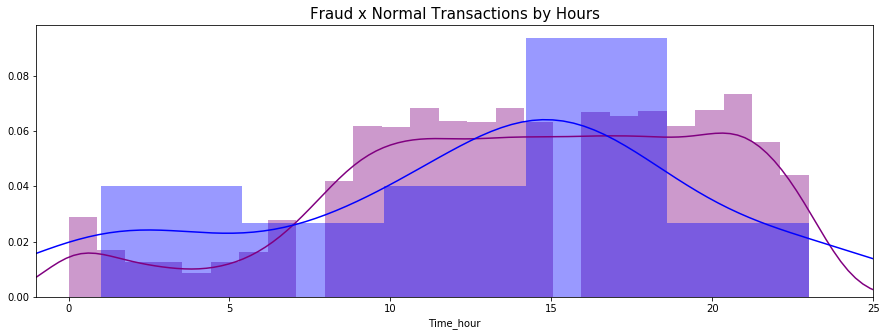

In [59]:
#Exploring the distribuition by Class types throught hours and minutes
plt.figure(figsize=(15,5))
sns.distplot(data[data['Class'] == 0]["Time_hour"], color='purple')
sns.distplot(data[data['Class'] == 1]["Time_hour"], color='blue')
plt.title('Fraud x Normal Transactions by Hours', fontsize=15)
plt.xlim([-1,25])

plt.show()

Interesting .. but still not clear. Let's create one scatter chart to display distribution by amount for each transaction.

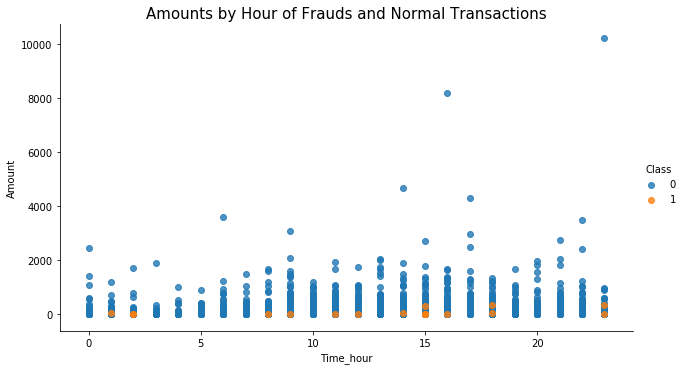

''

In [60]:
ax = sns.lmplot(y="Amount", x="Time_hour", fit_reg=False,aspect=1.8, data=data, hue='Class')
plt.title("Amounts by Hour of Frauds and Normal Transactions", fontsize=15)

plt.show()
;

### Correlation Matrix

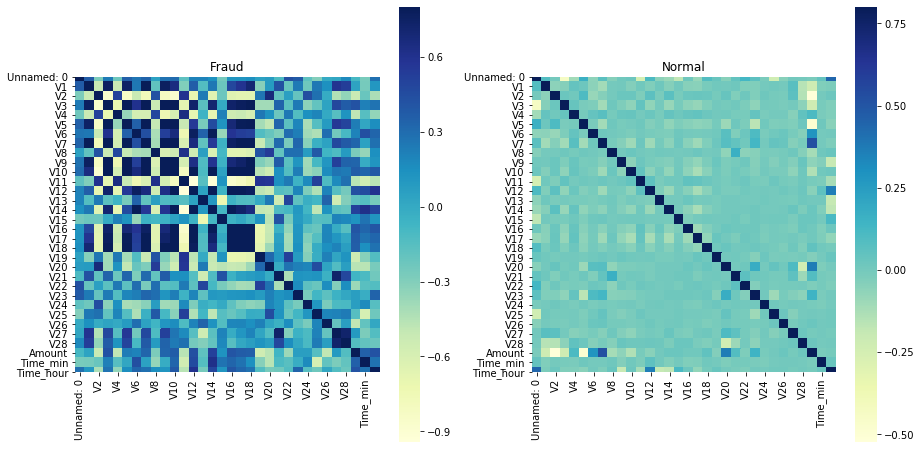

In [61]:
#correlation matrix 

f, (ax1, ax2) = plt.subplots(1,2,figsize =( 15, 8))

sns.heatmap(data.query('Class==1').drop(['Class','Time'],1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(data.query('Class==0').drop(['Class','Time'],1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

We can explore data further but at this moment, I would stop here and we will move to part two of the project which is pre-processing of our data.

# 2 - Pre-processing

In the first step of data exploration, I would like to first normalize the range of 'Amount' between -1 to +1. I have created a new column labelled as 'normalizedAmount'. We can use StandardScaler method provided by Scikit-learn liberary.

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler()

In [64]:
data['normalizedAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1,1))

In [65]:
# Let's drop useless columns which we will not be using here.

data = data.drop(['Amount'], axis=1)

In [66]:

data = data.drop(['Time'], axis=1)

In [67]:
data = data.drop(['Unnamed: 0'], axis=1)

In [68]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,Time_min,Time_hour,normalizedAmount
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03
mean,0.016628,-0.005726,-0.010398,-0.028731,-0.022065,0.000739,0.016121,-0.004941,-0.013924,0.003476,...,0.006422,-0.000855,-0.000284,0.000740,-0.006161,0.005893,0.002125,29.199375,14.074250,-5.329071e-18
std,1.899212,1.545809,1.477050,1.426184,1.401964,1.332905,1.305012,1.174568,1.106161,1.115539,...,0.553929,0.606846,0.513374,0.485101,0.394584,0.348770,0.046052,17.451281,5.792835,1.000063e+00
min,-29.973363,-29.198899,-19.947726,-5.416315,-40.427726,-7.810116,-21.234463,-26.069936,-8.739670,-18.271168,...,-12.667179,-2.814898,-3.223535,-1.511259,-5.809357,-3.693525,0.000000,0.000000,0.000000,-3.446530e-01
25%,-0.915243,-0.610001,-0.893566,-0.903137,-0.714806,-0.790640,-0.560447,-0.215935,-0.653245,-0.539930,...,-0.159989,-0.345288,-0.311490,-0.327823,-0.071358,-0.052957,0.000000,14.000000,10.000000,-3.216298e-01
50%,0.025737,0.040064,0.165369,-0.035525,-0.076317,-0.282476,0.043119,0.019278,-0.057401,-0.080901,...,-0.008716,0.038126,0.023790,-0.061720,0.000514,0.011239,0.000000,29.000000,15.000000,-2.568074e-01
75%,1.321858,0.784179,0.991859,0.752604,0.601602,0.403259,0.581711,0.331131,0.594168,0.479145,...,0.144751,0.440633,0.344371,0.246298,0.086333,0.076835,0.000000,45.000000,19.000000,-4.318959e-02
max,2.373022,11.447082,3.985446,9.074932,13.815072,23.917837,44.054461,9.561121,7.938980,11.790995,...,19.228169,3.577753,2.520869,2.693658,5.352193,15.649134,1.000000,59.000000,23.000000,3.885795e+01


### Splitting the Dataset

In [69]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RANDOM_SEED)

In [71]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [72]:
print('Shape of X_train :', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train :', y_test.shape)
print('Shape of y_test :', y_test.shape)

Shape of X_train : (5600, 31)
Shape of X_test: (2400, 31)
Shape of y_train : (2400, 1)
Shape of y_test : (2400, 1)


# 3 - Our Model

In [73]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [74]:
X_test.shape, X_train.shape

((2400, 31), (5600, 31))

In [75]:
model = Sequential([
    Dense(units=16, input_dim = 31, activation='relu'),
    Dense(units=24, activation='relu'),
    Dropout(0.5), #adjusting overfitting, chose probablity 0.5
    Dense(20,activation='relu'),
    Dense(24,activation='relu'),
    Dense(1,activation='sigmoid'),
])
;

''

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                512       
_________________________________________________________________
dense_7 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 25        
Total params: 1,949
Trainable params: 1,949
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [77]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=16, epochs=50)
;

Epoch 1/50
5600/5600 [==============================] - 2s 332us/step - loss: 0.0381 - acc: 0.9970
Epoch 2/50
5600/5600 [==============================] - 1s 142us/step - loss: 0.0249 - acc: 0.9971
Epoch 3/50
5600/5600 [==============================] - 1s 120us/step - loss: 0.0251 - acc: 0.9971
Epoch 4/50
5600/5600 [==============================] - 1s 130us/step - loss: 0.0162 - acc: 0.9971
Epoch 5/50
5600/5600 [==============================] - 1s 127us/step - loss: 0.0171 - acc: 0.9971
Epoch 6/50
5600/5600 [==============================] - 1s 119us/step - loss: 0.0158 - acc: 0.9971
Epoch 7/50
5600/5600 [==============================] - 1s 120us/step - loss: 0.0174 - acc: 0.9971
Epoch 8/50
5600/5600 [==============================] - 1s 117us/step - loss: 0.0143 - acc: 0.9971
Epoch 9/50
5600/5600 [==============================] - 1s 113us/step - loss: 0.0131 - acc: 0.9970
Epoch 10/50
5600/5600 [==============================] - 1s 113us/step - loss: 0.0132 - acc: 0.9971
Epoch 11/

''

### Model Evaluation

In [78]:
score = model.evaluate(X_test, y_test)

2400/2400 [==============================] - 0s 80us/step


In [79]:
print(score)

[0.003436730133042829, 0.99875]


This means that we have achieved <strong> very high accuracy (99.87%) </strong>. But this score rate may not valid since we want to exactly catch fraudulent transactions though our model. So let's check precision and also display reuslts in confusion matrix to check if our model is catching fraudulent transactions or not.

### Confusion Matrix

In [80]:
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalize Confusion Matrix")
    else:
        print("Confusion Matrix, Without Normalization")
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", color="white" if cm[i, j]>thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

In [81]:
y_test = pd.DataFrame(y_test)
y_pred = model.predict(X_test)

In [82]:
cnf_matrix = confusion_matrix(y_test, y_pred.round())

In [83]:
print(cnf_matrix)

[[2396    3]
 [   0    1]]


Confusion Matrix, Without Normalization
[[2396    3]
 [   0    1]]


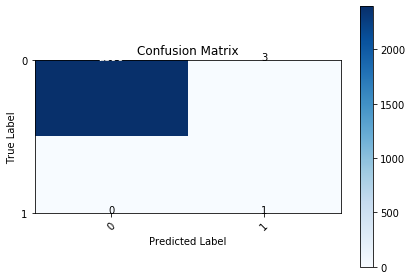

In [84]:
plot_confusion_matrix(cnf_matrix, classes=[0,1])

# Conclusion

Our model achieved good accuracy but note that data is small. We need more data to perform better analysis.

We can say that almost every non-fraudulent transaction, our model detected correctly. Only 3 transctions were falsely detected by our model.

Let's run our model on whole dataset.

Confusion Matrix, Without Normalization
[[7979    4]
 [   0   17]]


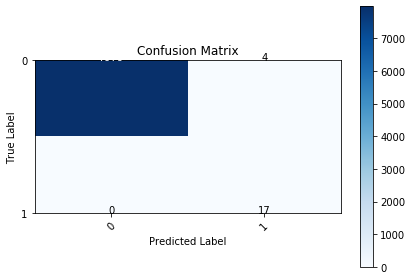

In [85]:
y_pred = model.predict(X)
y_expected = pd.DataFrame(y)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes=[0,1])
plt.show()

On the complete dataset, our model mismatached only 4 transactions.